Import libraries


In [1]:
import lasio
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

plt.style.use("bmh")

Read LAS and make a dataframe of a set interval

In [2]:
lasfile = lasio.read("36_7-3.las")

logs = lasfile.df()

logs.reset_index(inplace=True)


logs = logs.loc[(logs["DEPT"] >= 2500)  & (logs["DEPT"] <= 2700)].reset_index()



Read the table containing the components log responses and make a dictionary of responses

In [3]:
responses_table = pd.read_excel("log_responses.xlsx", index_col=0)

response_dict = responses_table.to_dict(orient="dict")

responses ={}
for i in response_dict:
    for j in response_dict[i]:
        responses[(j + "_" + i)] = response_dict[i][j]

responses

{'GR_QUARTZ': 40.0,
 'NPHI_QUARTZ': -0.04,
 'RHOB_QUARTZ': 2.65,
 'DTC_QUARTZ': 55.0,
 'PEF_QUARTZ': 1.8,
 'GR_CALCITE': 0.0,
 'NPHI_CALCITE': 0.0,
 'RHOB_CALCITE': 2.71,
 'DTC_CALCITE': 47.6,
 'PEF_CALCITE': 5.08,
 'GR_DOLOMITE': 0.0,
 'NPHI_DOLOMITE': 0.009,
 'RHOB_DOLOMITE': 2.87,
 'DTC_DOLOMITE': 43.5,
 'PEF_DOLOMITE': 3.14,
 'GR_SH': 160.0,
 'NPHI_SH': 0.3,
 'RHOB_SH': 2.5,
 'DTC_SH': 110.0,
 'PEF_SH': 2.2,
 'GR_MUD': 0.0,
 'NPHI_MUD': 1.0,
 'RHOB_MUD': 1.3,
 'DTC_MUD': 180.0,
 'PEF_MUD': 0.0}

Just a starting an starting point of volumen fraction

In [4]:
VOL_QUARTZ  = 0.2
VOL_CALCITE  = 0.2
VOL_DOLOMITE  = 0.2
VOL_SH  = 0.2
VOL_MUD  = 0.2

This is the placeholder of the model recontructed logs

In [5]:
logs["GR_RECON"] = VOL_QUARTZ*responses["GR_QUARTZ"] + VOL_CALCITE*responses["GR_CALCITE"] +VOL_DOLOMITE*responses["GR_DOLOMITE"] +VOL_SH*responses["GR_SH"] +VOL_MUD*responses["GR_MUD"]
logs["NPHI_RECON"] = VOL_QUARTZ*responses["NPHI_QUARTZ"] + VOL_CALCITE*responses["NPHI_CALCITE"] +VOL_DOLOMITE*responses["NPHI_DOLOMITE"] +VOL_SH*responses["NPHI_SH"] +VOL_MUD*responses["NPHI_MUD"]
logs["RHOB_RECON"] = VOL_QUARTZ*responses["RHOB_QUARTZ"] + VOL_CALCITE*responses["RHOB_CALCITE"] +VOL_DOLOMITE*responses["RHOB_DOLOMITE"] +VOL_SH*responses["RHOB_SH"] +VOL_MUD*responses["RHOB_MUD"]
logs["DTC_RECON"] = VOL_QUARTZ*responses["DTC_QUARTZ"] + VOL_CALCITE*responses["DTC_CALCITE"] +VOL_DOLOMITE*responses["DTC_DOLOMITE"] +VOL_SH*responses["DTC_SH"] +VOL_MUD*responses["DTC_MUD"]
logs["PEF_RECON"] = VOL_QUARTZ*responses["PEF_QUARTZ"] + VOL_CALCITE*responses["PEF_CALCITE"] +VOL_DOLOMITE*responses["PEF_DOLOMITE"] +VOL_SH*responses["PEF_SH"] +VOL_MUD*responses["PEF_MUD"]


Start optimization

In [6]:
from scipy.optimize import minimize

The objective function to minimize the error of reconstructed logs

In [7]:
def error_recon(volumes, *args):
    VOL_QUARTZ, VOL_CALCITE, VOL_DOLOMITE, VOL_SH, VOL_MUD = volumes
    GR, NPHI, RHOB, DTC, PEF = args
    GR_RECON = VOL_QUARTZ*responses["GR_QUARTZ"] + VOL_CALCITE*responses["GR_CALCITE"] +VOL_DOLOMITE*responses["GR_DOLOMITE"] +VOL_SH*responses["GR_SH"] +VOL_MUD*responses["GR_MUD"]
    NPHI_RECON = VOL_QUARTZ*responses["NPHI_QUARTZ"] + VOL_CALCITE*responses["NPHI_CALCITE"] +VOL_DOLOMITE*responses["NPHI_DOLOMITE"] +VOL_SH*responses["NPHI_SH"] +VOL_MUD*responses["NPHI_MUD"]
    RHOB_RECON = VOL_QUARTZ*responses["RHOB_QUARTZ"] + VOL_CALCITE*responses["RHOB_CALCITE"] +VOL_DOLOMITE*responses["RHOB_DOLOMITE"] +VOL_SH*responses["RHOB_SH"] +VOL_MUD*responses["RHOB_MUD"]
    DTC_RECON = VOL_QUARTZ*responses["DTC_QUARTZ"] + VOL_CALCITE*responses["DTC_CALCITE"] +VOL_DOLOMITE*responses["DTC_DOLOMITE"] +VOL_SH*responses["DTC_SH"] +VOL_MUD*responses["DTC_MUD"]
    PEF_RECON = VOL_QUARTZ*responses["PEF_QUARTZ"] + VOL_CALCITE*responses["PEF_CALCITE"] +VOL_DOLOMITE*responses["PEF_DOLOMITE"] +VOL_SH*responses["PEF_SH"] +VOL_MUD*responses["PEF_MUD"]


    #Some magic numbers to adjust the precision of differents magnitude orders (needs improvement)
    return (GR-GR_RECON)**2 + (NPHI*300- NPHI_RECON*300)**2 + (RHOB*100 - 100*RHOB_RECON)**2 + (DTC - DTC_RECON)**2 + (PEF -PEF_RECON)**2


Set the volumn bounds

In [8]:
#Mineral volumen bounds
bnds = ((0, 1), (0, 1), (0, 0.1), (0, 1), (0, 0.45))

A constraint to make the sum of volumes total equal 1

In [9]:
def constraint1(x):
    return x[0]+x[1]+x[2]+x[3]+x[4]-1

cons = [{"type": "eq", "fun": constraint1}]


Here we calculate the volumen at each depth (row) calling the optimization object and create the volumen logs and recontructed inputs logs

In [10]:
for i in range(len(logs)):
    res = minimize(error_recon, ((0, 0, 0, 0, 0)), args=(logs.loc[i, "GR"], logs.loc[i, "NPHI"], logs.loc[i, "RHOB"], logs.loc[i, "DTC"], logs.loc[i, "PEF"]), bounds= bnds, constraints=cons)
    VOL_QUARTZ  = res.x[0]
    VOL_CALCITE  = res.x[1]
    VOL_DOLOMITE  = res.x[2]
    VOL_SH  = res.x[3]
    VOL_MUD  = res.x[4]
    
    logs.loc[i, "GR_RECON"] = VOL_QUARTZ*responses["GR_QUARTZ"] + VOL_CALCITE*responses["GR_CALCITE"] +VOL_DOLOMITE*responses["GR_DOLOMITE"] +VOL_SH*responses["GR_SH"] +VOL_MUD*responses["GR_MUD"]
    logs.loc[i, "NPHI_RECON"] = VOL_QUARTZ*responses["NPHI_QUARTZ"] + VOL_CALCITE*responses["NPHI_CALCITE"] +VOL_DOLOMITE*responses["NPHI_DOLOMITE"] +VOL_SH*responses["NPHI_SH"] +VOL_MUD*responses["NPHI_MUD"]
    logs.loc[i, "RHOB_RECON"] = VOL_QUARTZ*responses["RHOB_QUARTZ"] + VOL_CALCITE*responses["RHOB_CALCITE"] +VOL_DOLOMITE*responses["RHOB_DOLOMITE"] +VOL_SH*responses["RHOB_SH"] +VOL_MUD*responses["RHOB_MUD"]
    logs.loc[i, "DTC_RECON"] = VOL_QUARTZ*responses["DTC_QUARTZ"] + VOL_CALCITE*responses["DTC_CALCITE"] +VOL_DOLOMITE*responses["DTC_DOLOMITE"] +VOL_SH*responses["DTC_SH"] +VOL_MUD*responses["DTC_MUD"]
    logs.loc[i, "PEF_RECON"] = VOL_QUARTZ*responses["PEF_QUARTZ"] + VOL_CALCITE*responses["PEF_CALCITE"] +VOL_DOLOMITE*responses["PEF_DOLOMITE"] +VOL_SH*responses["PEF_SH"] +VOL_MUD*responses["PEF_MUD"]

    logs.loc[i, "VOL_QUARTZ"] = VOL_QUARTZ
    logs.loc[i, "VOL_CALCITE"] = VOL_CALCITE
    logs.loc[i, "VOL_DOLOMITE"] = VOL_DOLOMITE
    logs.loc[i, "VOL_SH"] = VOL_SH
    logs.loc[i, "VOL_MUD"] = VOL_MUD

/home/ruben/.venv-3.11.4/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


The plotting section

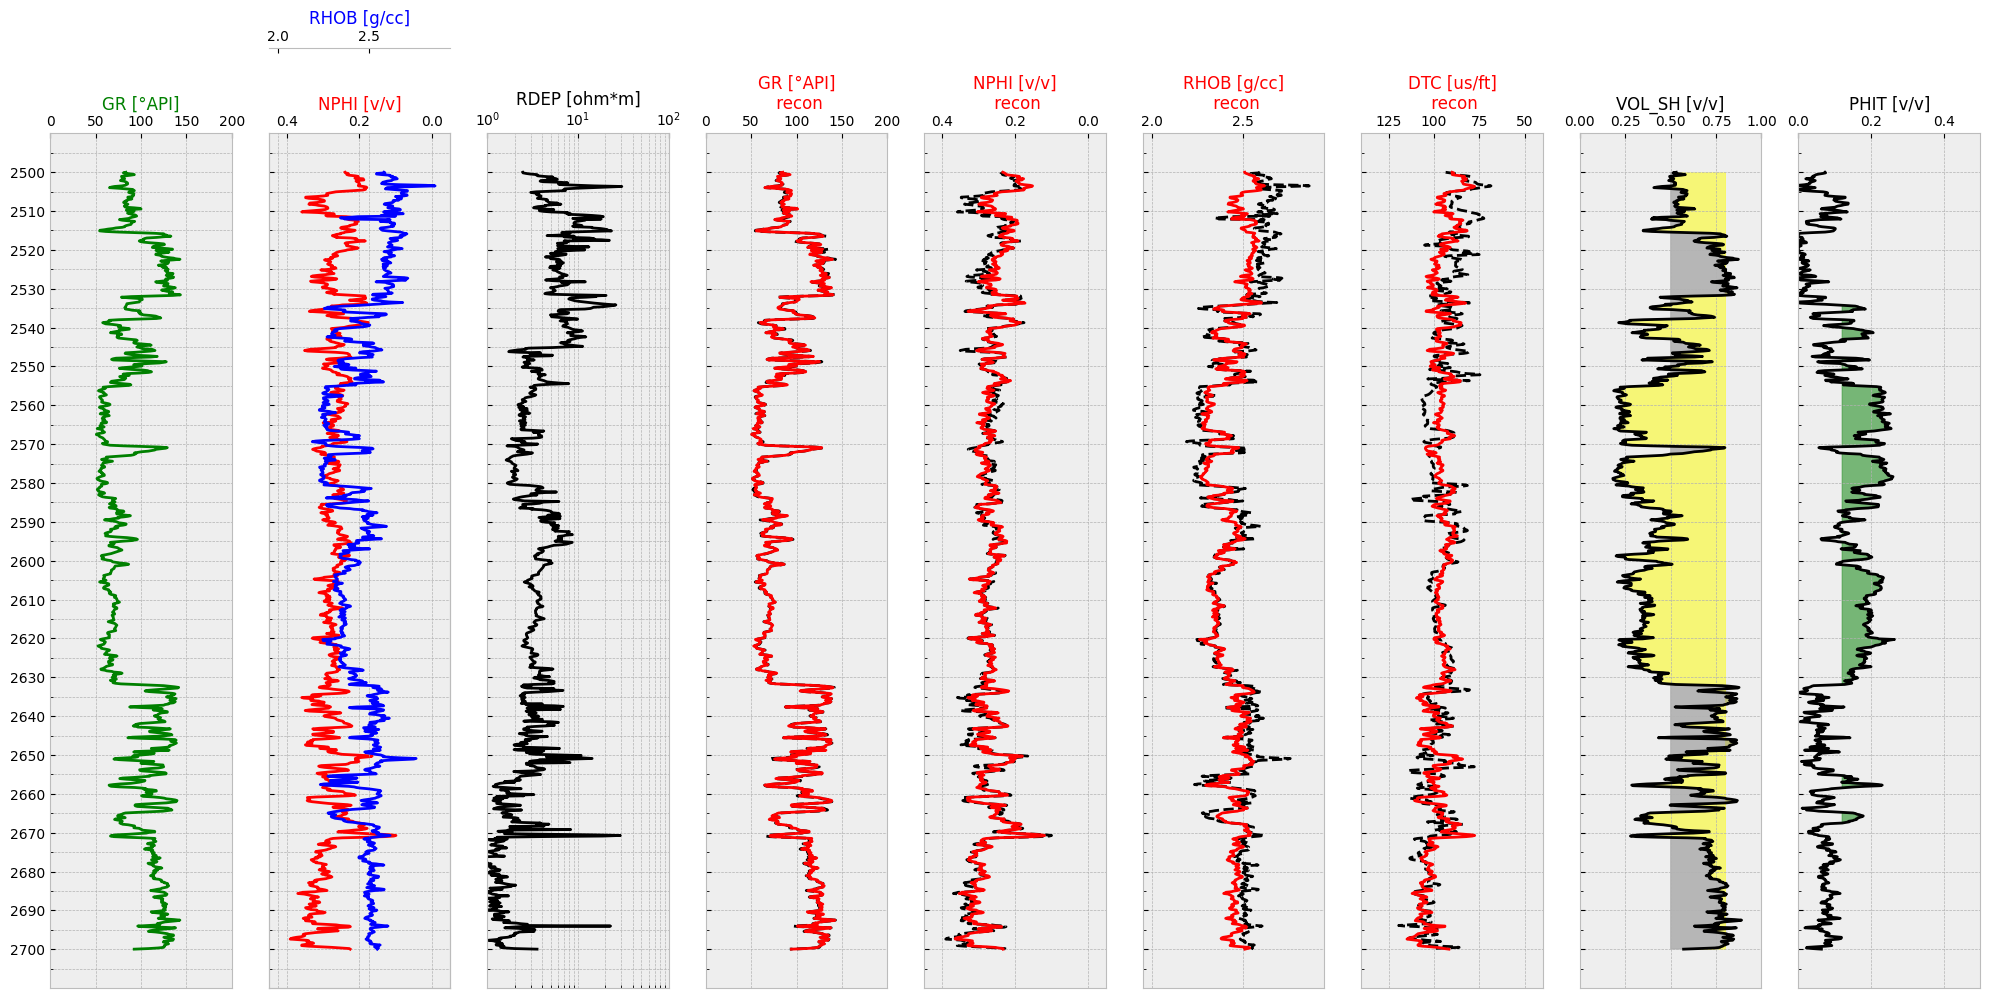

In [11]:
fig = plt.figure(figsize=(20, 10))

ax =[]

ax.append(fig.add_subplot(1, 9, (1, 1)))
ax.append(fig.add_subplot(1, 9, (2, 2), sharey=ax[0]))
ax.append(fig.add_subplot(1, 9, (3, 3), sharey=ax[0]))
ax.append(fig.add_subplot(1, 9, (4, 4), sharey=ax[0]))
ax.append(fig.add_subplot(1, 9, (5, 5), sharey=ax[0]))
ax.append(fig.add_subplot(1, 9, (6, 6), sharey=ax[0]))
ax.append(fig.add_subplot(1, 9, (7, 7), sharey=ax[0]))
ax.append(fig.add_subplot(1, 9, (8, 8), sharey=ax[0]))
ax.append(fig.add_subplot(1, 9, (9, 9), sharey=ax[0]))


ax[0].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(10))
ax[0].yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(5))


ax[0].invert_yaxis()

ax[0].plot(logs["GR"], logs["DEPT"], color="green")
ax[0].set_xlabel("GR [°API]", color="green")
ax[0].tick_params(which="both", top=True, labeltop=True, bottom=False, labelbottom=False)
ax[0].xaxis.set_label_position("top")
ax[0].set_xlim(0, 200)
ax[0].grid(True, which="both")


t1 = ax[1].twiny()
t1.plot(logs["RHOB"], logs["DEPT"], color="blue")
t1.set_xlabel("RHOB [g/cc]", color ="blue")
t1.tick_params(labelleft=False, top=True, labeltop=True, bottom=False, labelbottom=False)
t1.xaxis.set_label_position("top")

t1.spines.top.set_position(("axes",1.1))
t1.set_xlim(1.95, 2.95)


#t2 = ax[1].twiny()
#t2.plot(logs["DTC"], logs["DEPT"], color="green")
#t2.set_xlabel("DTC [us/ft]")
#t2.tick_params(labelleft=False, top=True, labeltop=True, bottom=False, labelbottom=False)
#t2.xaxis.set_label_position("top")

#t2.spines.top.set_position(("axes",1.06))
#t2.set_xlim(140, 40)

ax[1].plot(logs["NPHI"], logs["DEPT"], color="red")
ax[1].set_xlabel("NPHI [v/v]", color="red")
ax[1].tick_params(labelleft=False, top=True, labeltop=True, bottom=False, labelbottom=False)
ax[1].xaxis.set_label_position("top")
ax[1].set_xlim(0.45, -0.05)
ax[1].grid(True, which="both")

ax[2].semilogx(logs["RDEP"], logs["DEPT"], color="black")
ax[2].set_xlabel("RDEP [ohm*m]")
ax[2].tick_params(labelleft=False, top=True, labeltop=True, bottom=False, labelbottom=False)
ax[2].xaxis.set_label_position("top")
ax[2].set_xlim(1, 100)
ax[2].grid(True, which="both")


ax[3].plot(logs["GR"], logs["DEPT"], "--", color="black")
ax[3].plot(logs["GR_RECON"], logs["DEPT"], "-", color="red")
ax[3].set_xlim(0, 200)
ax[3].set_xlabel("GR [°API]\n recon", color ="red")
ax[3].xaxis.set_label_position("top")
ax[3].tick_params(labelleft=False, top=True, labeltop=True, bottom=False, labelbottom=False)

ax[4].tick_params(labelleft=False, top=True, labeltop=True, bottom=False, labelbottom=False)
ax[4].set_xlabel("NPHI [v/v]\n recon", color ="red")
ax[4].xaxis.set_label_position("top")
ax[4].plot(logs["NPHI"], logs["DEPT"], "--", color="black")
ax[4].plot(logs["NPHI_RECON"], logs["DEPT"], "-", color="red")
ax[4].set_xlim(0.45, -0.05)


ax[5].set_xlabel("RHOB [g/cc]\n recon", color ="red")
ax[5].xaxis.set_label_position("top")
ax[5].tick_params(labelleft=False, top=True, labeltop=True, bottom=False, labelbottom=False)
ax[5].plot(logs["RHOB"], logs["DEPT"], "--", color="black")
ax[5].plot(logs["RHOB_RECON"], logs["DEPT"], "-", color="red")
ax[5].set_xlim(1.95, 2.95)


ax[6].set_xlabel("DTC [us/ft]\n recon", color ="red")
ax[6].xaxis.set_label_position("top")
ax[6].tick_params(labelleft=False, top=True, labeltop=True, bottom=False, labelbottom=False)
ax[6].plot(logs["DTC"], logs["DEPT"], "--", color="black")
ax[6].plot(logs["DTC_RECON"], logs["DEPT"], "-", color="red")
ax[6].set_xlim(140, 40)

#ax[7].tick_params(labelleft=False, top=True, labeltop=True, bottom=False, labelbottom=False)
#ax[7].plot(logs["PEF"], logs["DEPT"], "--", color="black")
#ax[7].plot(logs["PEF_RECON"], logs["DEPT"], "-", color="red")
#ax[7].set_xlim(0, 5)


ax[7].set_xlabel("VOL_SH [v/v]")
ax[7].xaxis.set_label_position("top")
ax[7].tick_params(labelleft=False, top=True, labeltop=True, bottom=False, labelbottom=False)
ax[7].plot(logs["VOL_SH"], logs["DEPT"], "-", color="black")
ax[7].set_xlim(0, 1)
ax[7].fill_betweenx(logs["DEPT"], 0.8, logs["VOL_SH"], color="yellow", alpha=0.5)
ax[7].fill_betweenx(logs["DEPT"], 0.5, logs["VOL_SH"], where=logs["VOL_SH"]>0.5, color="gray", alpha=0.5)

ax[8].set_xlabel("PHIT [v/v]")
ax[8].xaxis.set_label_position("top")
ax[8].tick_params(labelleft=False, top=True, labeltop=True, bottom=False, labelbottom=False)
ax[8].plot(logs["VOL_MUD"], logs["DEPT"], "-", color="black")
ax[8].set_xlim(0, 0.5)
ax[8].fill_betweenx(logs["DEPT"], 0.12, logs["VOL_MUD"], where=logs["VOL_MUD"]>0.12, color="green", alpha=0.5)

fig.tight_layout()
fig.savefig("fig1.png", bbox_inches="tight")


plt.show()